In [1]:
# https://www.kaggle.com/yaroshevskiy/enron-top-10-senders-classification

In [1]:
import numpy as np
import pandas as pd
import re
import random
import email
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics 
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.cross_validation import train_test_split
from sklearn.decomposition import TruncatedSVD

from scipy.sparse import coo_matrix, hstack

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
enron_data = pd.read_csv("emails.csv", header=0, quoting=2)

In [4]:
enron_data.head()

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [4]:
#list(enron_data.file.unique()) #Checking what types of emails exist, e.g. sent, etc.

In [11]:
# filtering only those that contain 'sent' in file name (f.e _sent_mail, sent_mail, sent etc) 

enron_sent = enron_data[enron_data["file"].str.contains('sent').tolist()]
enron_sent.head(10)

,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...
5,allen-p/_sent_mail/1002.,Message-ID: <30965995.1075863688265.JavaMail.e...
6,allen-p/_sent_mail/1003.,Message-ID: <16254169.1075863688286.JavaMail.e...
7,allen-p/_sent_mail/1004.,Message-ID: <17189699.1075863688308.JavaMail.e...
8,allen-p/_sent_mail/101.,Message-ID: <20641191.1075855687472.JavaMail.e...
9,allen-p/_sent_mail/102.,Message-ID: <30795301.1075855687494.JavaMail.e...


In [12]:
In [14]: enron_sent['start'], enron_sent['end'], enron_sent['fileno'] = zip(*enron_sent['file'].map(lambda x: x.split('/')))
enron_sent.head()

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,file,message,start,end,fileno
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...,allen-p,_sent_mail,1.
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...,allen-p,_sent_mail,10.
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...,allen-p,_sent_mail,100.
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...,allen-p,_sent_mail,1000.
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...,allen-p,_sent_mail,1001.


In [13]:
# extracting senders (there might me cases like "orgname/sender" but so far as we need only top 10 senders we are ok)

enron_sent = enron_sent.assign(sender=enron_sent["file"].map(lambda x: re.search("(.*)/.*sent", x).group(1)).values)
enron_sent.drop("file", axis=1, inplace=True)
enron_sent["sender"].value_counts().head(10)

mann-k          8926
kaminski-v      8644
dasovich-j      5366
germany-c       5128
shackleton-s    4407
jones-t         4123
bass-e          3030
lenhart-m       2759
beck-s          2674
symes-k         2649
Name: sender, dtype: int64

In [14]:
# mapping top senders' names to use later as label series
# we work only with top 10 senders

top_senders = enron_sent["sender"].value_counts().head(10).index.values
mapping = dict(zip(top_senders, range(10)))
print(mapping)

{'mann-k': 0, 'kaminski-v': 1, 'dasovich-j': 2, 'germany-c': 3, 'shackleton-s': 4, 'jones-t': 5, 'bass-e': 6, 'lenhart-m': 7, 'beck-s': 8, 'symes-k': 9}


In [15]:
# info

print(enron_sent.shape)
print(enron_sent[enron_sent.sender.isin(top_senders)].shape)

enron_sent = enron_sent[enron_sent.sender.isin(top_senders)]

(126846, 5)
(47706, 5)


In [28]:
print(enron_sent.iloc[random.randint(0, enron_sent.shape[0]), 0])

Message-ID: <15772908.1075841901461.JavaMail.evans@thyme>
Date: Fri, 23 Mar 2001 08:13:00 -0800 (PST)
From: kate.symes@enron.com
To: elliot.mainzer@enron.com
Subject: Re: bananas and other things you can call me with
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Kate Symes
X-To: Elliot Mainzer
X-cc: 
X-bcc: 
X-Folder: \kate symes 6-27-02\Notes Folders\Sent
X-Origin: SYMES-K
X-FileName: kate symes 6-27-02.nsf

---------------------- Forwarded by Kate Symes/PDX/ECT on 03/23/2001 04:17 PM 
---------------------------


"Winston Goodbody" <wgoodbody@hotmail.com> on 03/23/2001 04:20:30 PM
To: Kate.Symes@enron.com
cc:  

Subject: Re: bananas and other things you can call me with


Hi Kate,

Thanks for the email.  Sorry it's taken me a while to respond but it's chaos
here as we prepare to head off for the next part of our trip today.  Glad to
hear the glow of the screen still has you enthralled.  Keep hitting F9 and
all will be well.  The

In [16]:
# now let's take a look at random email

print(enron_sent.iloc[random.randint(0, enron_sent.shape[0]), 0])

Message-ID: <33331751.1075844927705.JavaMail.evans@thyme>
Date: Wed, 23 May 2001 04:23:00 -0700 (PDT)
From: sara.shackleton@enron.com
To: david.wall@enron.com
Subject: Adding authorized traders to the ENA Authorized Trader List
Cc: marie.heard@enron.com
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
Bcc: marie.heard@enron.com
X-From: Sara Shackleton
X-To: David A Wall
X-cc: Marie Heard
X-bcc: 
X-Folder: \Sara_Shackleton_Dec2000_June2001_2\Notes Folders\Sent
X-Origin: SHACKLETON-S
X-FileName: sshackle.nsf

David:

Please send an email request to Cassandra Schultz and Veronica Valdez 
requesting that the following Enron Credit Inc. traders be added to the ENA 
Authorized Trader List (for the purpose of using ENA executed ISDA Master 
Agreements in the credit trading area, such as Swiss Re and First Union 
National Bank):

Jeff Kinneman
Nicholas Stephan
Paul Pizzolato

Please copy me and Marie Heard.  Call if you have any questions.  Thanks.



In [17]:
# I use default email library just for simplicity. For real product I would use more complicated parsing tools or write my own
# We extract email artificials and content from raw text

def email_from_string(raw_email):
    msg = email.message_from_string(raw_email)
    
    content = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            content.append(part.get_payload())
            
    result = {}
    for key in msg.keys(): 
        result[key] = msg[key]
    result["content"] = ''.join(content)
    
    return result

In [18]:
enron_parsed = pd.DataFrame(list(map(email_from_string, enron_sent.message)))
enron_parsed.head(1)

,Bcc,Cc,Content-Transfer-Encoding,Content-Type,Date,From,Message-ID,Mime-Version,Subject,To,X-FileName,X-Folder,X-From,X-Origin,X-To,X-bcc,X-cc,content
0,NaN,NaN,7bit,text/plain; charset=us-ascii,"Fri, 9 Mar 2001 11:24:00 -0800 (PST)",eric.bass@enron.com,<17027752.1075840325838.JavaMail.evans@thyme>,1.0,Rebook - QU0663 Mirant,chance.rabon@enron.com,eric bass 6-25-02.PST,"\ExMerge - Bass, Eric\'Sent Mail",Eric Bass,BASS-E,Chance Rabon <Chance Rabon/ENRON@enronXgate>,,,\n---------------------- Forwarded by Eric Bas...


In [19]:
# cc and bcc stand for carbon copy and blind carbon copy and that may be useful for classification
# Also we might use "To" or any other metadata but I believe the idea of this work is to use simply "content" + "subject" 

enron_parsed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47706 entries, 0 to 47705
Data columns (total 18 columns):
Bcc                          9259 non-null object
Cc                           9259 non-null object
Content-Transfer-Encoding    47706 non-null object
Content-Type                 47706 non-null object
Date                         47706 non-null object
From                         47706 non-null object
Message-ID                   47706 non-null object
Mime-Version                 47706 non-null object
Subject                      47706 non-null object
To                           47640 non-null object
X-FileName                   47706 non-null object
X-Folder                     47706 non-null object
X-From                       47706 non-null object
X-Origin                     47706 non-null object
X-To                         47706 non-null object
X-bcc                        47706 non-null object
X-cc                         47706 non-null object
content                   

In [20]:
#here we do simply two things: 1 remove numbers and 2 remove stowords using nltk stopwords corpus

def content_to_wordlist( content, remove_stopwords=False ):
    content = re.sub("[^a-zA-Z]"," ", content)
    words = content.lower().split()
    
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]

    return ' '.join(words)

In [21]:
# enron_parsed['To'] = enron_parsed['To'].astype(str) # in case we want to use 'To' as information
data = pd.DataFrame(list(map(content_to_wordlist, 
                          enron_parsed[['Subject', 'content']].apply(lambda x: ' '.join(x), axis=1))), 
                          columns = ["content"])

In [26]:
data = data.assign(sender=enron_sent["sender"].values)
data = data.replace({'sender': mapping})
(data.content)

0        rebook qu mirant forwarded by eric bass hou ec...
1        for your viewing pleasure forwarded by eric ba...
2        re fw christmas i think we are going to stay i...
3        re i didn t go either today is legs and lower ...
4        fwd the perils of limbo forwarded by eric bass...
5        re fw winning the cultural war that s good new...
6        fw winning the cultural war forwarded by eric ...
7        re please effective date of your current rotat...
8        re it only takes about minutes to get to highl...
9        re airfare i m ready we could try to do it ove...
10       airfare someone i know just put in a bid on pr...
11       steamboat vacation information here is some in...
12       re michael is a happily married man he would n...
13       re new work number have you bought any new dvd...
14                                  index here is the info
15       re i hope you were only thinking good things i...
16                    did you have a good birthday weeke

In [20]:
# now we split data for training and test sets

X_train, X_test, y_train, y_test = train_test_split(data.content.values, data.sender.values, test_size=0.25)

In [21]:
# 72k features!
X_train.shape

(35779,)

In [22]:
# lets vectorize our content using default params

vect = TfidfVectorizer(sublinear_tf=True, use_idf=True)
X_train = vect.fit_transform(data_train)
X_test = vect.transform(data_test)

In [23]:
# let's try to use simple feature selection using l1 regularization and default threshold

clf = LogisticRegression(penalty='l1')
clf.fit(X_train, y_train)

model = SelectFromModel(clf, prefit=True)
X_train_new = model.transform(X_train)

X_train_new.shape

(35779, 2217)

In [24]:
# non linear methods? I skip GradientBoostingClassifier for now because of my laptop low productivity :(
# we will use cross validation with 3 folds for estimation

for classifier in [LinearSVC, LogisticRegression, SGDClassifier, RandomForestClassifier]:
    print(cross_val_score(classifier(), X_train_new, y_train, cv=3).mean())

0.179909731344
0.192514969425


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/anaconda3/lib/python3.6/site-packages/s

0.150143502004
0.144945896619


In [25]:
clf = LogisticRegression(C=0.15, penalty='l1')
clf.fit(X_train, y_train)

n_comp = np.sum(np.abs(clf.coef_) > 1e-4)
print(n_comp)

tsvd = TruncatedSVD(n_components = n_comp)
X_train_pca = tsvd.fit_transform(X_train)

for classifier in [LinearSVC, LogisticRegression, SGDClassifier, RandomForestClassifier]:
    print(cross_val_score(classifier(), X_train_pca, y_train, cv=3).mean())

4
0.187400405814
0.187064966659


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
/anaconda3/lib/python3.6/site-packages/s

0.115229276084
0.138517322555


In [26]:
# let's fit min number of components for previous model

scores = []
for n_components in range(10, 100, 10):
    tsvd = TruncatedSVD(n_components = n_components)
    X_train_pca = tsvd.fit_transform(X_train)

    score = cross_val_score(LinearSVC(), X_train_pca, y_train, cv=3).mean()
    scores.append(score)
    print(score)

0.187651757819
0.18661765664
0.186701490645
0.186478067638
0.185751542192
0.187623894364
0.18594665647
0.187260783975
0.186841510834


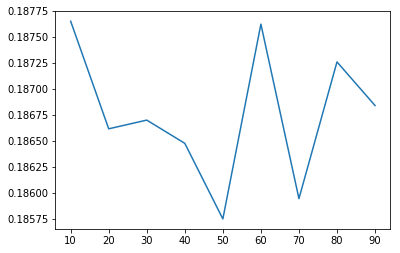

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(10, 100, 10), scores)
plt.show()

In [ ]:
#let's fit parameters for linear svm

tsvd = TruncatedSVD(n_components = 120)
X_train_pca = tsvd.fit_transform(X_train)

parameters = {'C':[0.1, 0.3, 0.5, 1, 3, 5, 10, 30]}
clf = GridSearchCV(LinearSVC(), parameters)
clf.fit(X_train_pca, y_train)

clf.grid_scores_

In [ ]:
# finally let's train the model on the test data and do some model evaluation

tsvd = TruncatedSVD(n_components = 120)
X_train_pca = tsvd.fit_transform(X_train)
X_test_pca = tsvd.transform(X_test)

clf = LinearSVC()
clf.fit(X_train_pca, y_train)

print(metrics.accuracy_score(y_test, clf.predict(X_test_pca)))

In [ ]:
confusion_matrix(y_test, clf.predict(X_test_pca))

In [ ]:
print(classification_report(y_test, clf.predict(X_test_pca), target_names=top_senders))

I believe we get these high scores with that small amount of features because of names/email addresses encoded in email raw content. But there were no bans fot this:) Let's try to add some email metadata:

In [ ]:
# we add To and Bcc/cc features from mail metadata to see if it will increase our accuracy:

enron_parsed['To'] = enron_parsed['To'].astype(str) 
data = pd.DataFrame(list(map(content_to_wordlist, enron_parsed[['Subject', 'content', 'To']]
                             .apply(lambda x: ' '.join(x), axis=1))), 
                          columns = ["content"])

In [ ]:
data['bcc'] = enron_parsed['Bcc'].isnull().astype(int)

data = data.assign(sender=enron_sent["sender"].values)
data = data.replace({'sender': mapping})
data.head()

In [ ]:
data_train, data_test, y_train, y_test = train_test_split(data[['content', 'bcc']], data['sender'], test_size=0.25)

vect = TfidfVectorizer(sublinear_tf=True, use_idf=True)
X_train = vect.fit_transform(data_train.content)
X_test = vect.transform(data_test.content)

X_train = hstack([coo_matrix(X_train), coo_matrix(data_train.bcc).transpose()])
X_test = hstack([coo_matrix(X_test), coo_matrix(data_test.bcc).transpose()])

In [ ]:
print(X_train.shape )
print(X_test.shape )

In [ ]:
tsvd = TruncatedSVD(n_components = 120)
X_train_pca = tsvd.fit_transform(X_train)
X_test_pca = tsvd.transform(X_test)

clf = LinearSVC()
clf.fit(X_train_pca, y_train)

print(metrics.accuracy_score(y_test, clf.predict(X_test_pca)))
print(metrics.f1_score(y_test, clf.predict(X_test_pca), average="weighted"))

In [ ]:
confusion_matrix(y_test, clf.predict(X_test_pca))

In [ ]:
print(classification_report(y_test, clf.predict(X_test_pca), target_names=top_senders))

So adding 'To' and 'Bcc' leads to slightly better result in classification. Of course to increase accuracy we need to do better preprocessing of raw emails f.e. to extract information from content of the mail (email addresses, references, forwards, names etc) but still we score a good one here. Unfortunately I was on able to run GradientBoostingClassifier, XGBoost models on this machine